In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib.colors import ListedColormap

In [4]:
df = pd.read_csv("train_data.csv", index_col = 0)

In [64]:
df.shape

(5000, 10)

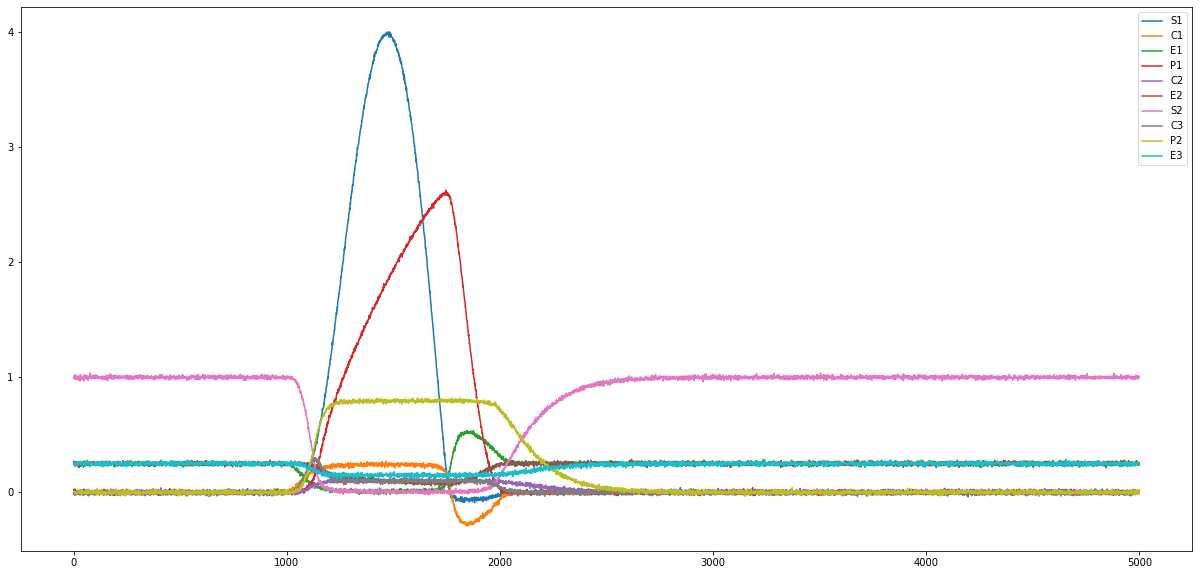

In [70]:
training_df = df + np.random.normal(0, 0.01, size = df.shape)

training_df.plot(figsize = (21, 10))
plt.show()

In [71]:
X_train = training_df[training_df.columns[df.columns != 'P2']].values
y_train = training_df['P2'].values

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).view([X_train.shape[0], 1])

X_test = df[df.columns[df.columns != 'P2']].values
y_test = df['P2'].values

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test).view([X_test.shape[0], 1])

In [72]:
X_train.shape

torch.Size([5000, 9])

In [73]:
num_epochs = 500
learning_rate = 0.01

input_size = 9
hidden_size = 2
num_layers = 1
num_classes = 1

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTMCell(1,51)
        self.lstm2 = nn.LSTMCell(51,51)
        self.linear = nn.Linear(51,9)
        
    def forward(self, inp, future = 0):
        outputs = list()
        h_t  = torch.zeros(inp.size(0), 51, dtype = torch.double)
        c_t  = torch.zeros(inp.size(0), 51, dtype = torch.double)
        h_t2 = torch.zeros(inp.size(0), 51, dtype = torch.double)
        c_t2 = torch.zeros(inp.size(0), 51, dtype = torch.double)
        for inp_t in inp.split(1, dim = 1):
            h_t, c_t = self.lstm1(inp_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.cat(outputs, dim = 1)
        return outputs

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.double()
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        

/home/darpan/.virtualenvs/gnn_interactive_project/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([5000, 1])) that is different to the input size (torch.Size([5000, 81])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.12358
Epoch: 100, loss: 0.02483
Epoch: 200, loss: 0.01317
Epoch: 300, loss: 0.00978
Epoch: 400, loss: 0.00844


In [85]:
modified_test = pd.read_csv("train_data_2.csv", index_col = 0)

In [91]:
X_mod_test = modified_test[modified_test.columns[modified_test.columns != 'P2']].values
y_mod_test = modified_test['P2'].values

X_mod_test = torch.from_numpy(X_mod_test)
y_mod_test = torch.from_numpy(y_mod_test).view([X_mod_test.shape[0], 1])

In [94]:
y_pred = lstm(X_mod_test)

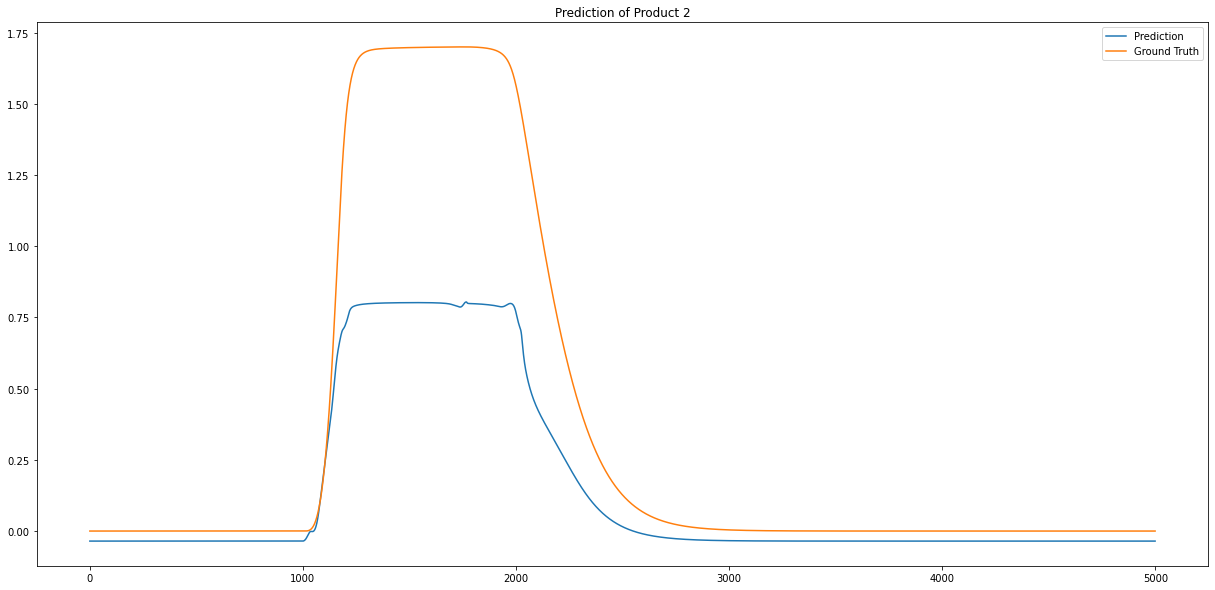

In [105]:
plt.figure(figsize = (21, 10))
plt.title("Prediction of Product 2")
plt.plot(y_pred.detach().numpy()[:, 50], label = 'Prediction')
plt.plot(y_mod_test, label = 'Ground Truth')
plt.legend()
plt.show()